In [1]:
from dataset import PairedDatasetDouble
pd = PairedDatasetDouble('In/0', 'In/1', 'Out_New', 200)

Length of x_train 0 files: 943
Length of x_train 1 files: 943
Length of y_train files: 943
Item 0 with max: 3482 and min: -2180
Normalized item 0 with max: 1.0 and min: 0.0
Item 1 with max: 1681 and min: -1108
Normalized item 1 with max: 1.0 and min: 0.0
Item 2 with max: 5660 and min: -2212
Normalized item 2 with max: 1.0 and min: 0.0
Item 3 with max: 3564 and min: -1221
Normalized item 3 with max: 1.0 and min: 0.0
Item 4 with max: 3452 and min: -2218
Normalized item 4 with max: 1.0 and min: 0.0
Item 5 with max: 3378 and min: -2213
Normalized item 5 with max: 1.0 and min: 0.0
Item 6 with max: 3744 and min: -2186
Normalized item 6 with max: 1.0 and min: 0.0
Item 7 with max: 3495 and min: -2201
Normalized item 7 with max: 1.0 and min: 0.0
Item 8 with max: 1730 and min: -1078
Normalized item 8 with max: 1.0 and min: 0.0
Item 9 with max: 3420 and min: -1118
Normalized item 9 with max: 1.0 and min: 0.0
Item 10 with max: 3547 and min: -2167
Normalized item 10 with max: 1.0 and min: 0.0
Item 

In [2]:
!conda install -y tensorflow-gpu"=>2.1.0"

Solving environment: | 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - defaults/linux-64::pandas==1.0.1=py36h0573a6f_0
  - defaults/noarch::jupyterlab==1.2.6=pyhf63ae98_0
  - defaults/linux-64::scikit-learn==0.22.1=py36hd81dba3_0
  - defaults/linux-64::python-language-server==0.31.7=py36_0
  - defaults/linux-64::bkcharts==0.2=py36_0
  - defaults/linux-64::nb_conda==2.2.1=py36_0
  - defaults/noarch::numpydoc==0.9.2=py_0
  - defaults/linux-64::pytest-arraydiff==0.3=py36h39e3cac_0
  - defaults/linux-64::bottleneck==1.3.2=py36heb32a55_0
  - defaults/linux-64::pywavelets==1.1.1=py36h7b6447c_0
  - defaults/noarch::pytest-astropy==0.8.0=py_0
  - defaults/linux-64::numexpr==2.7.1=py36h423224d_0
  - defaults/linux-64::nbconvert==5.6.1=py36_0
  - defaults/linux-64::h5py==2.10.0=py36h7918eee_0
  - defaults/linux-64::bokeh==1.4.0=py36_0
  - defaults/noarch::jupyterlab_server==1.0.6=py_0
  - defaults/linux-64::nump

In [3]:
from tensorflow.keras.models import load_model

model = load_model('dual_model_final.h5')

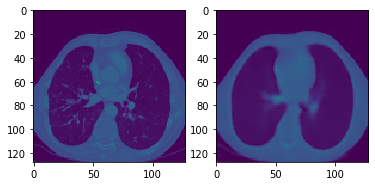

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage import measure, morphology

input_0 = np.reshape(pd.x_train_0[121], (1, 1024, 1024, 1))
input_1 = np.reshape(pd.x_train_1[121], (1, 1024, 1024, 1))

output = model.predict([input_0, input_1])
output = np.reshape(output, (128, 128, 128))

true_array = pd.y_train[121]

f = plt.figure()

f.add_subplot(1, 2, 1)
plt.imshow(true_array[64], vmin = 0, vmax = 1)

f.add_subplot(1, 2, 2)
plt.imshow(output[64], vmin = 0, vmax = 1)

plt.show()

In [7]:
print(np.amax(true_array))
print(np.amin(true_array))
print(np.amax(output))
print(np.amin(output))


1.0
0.0
0.9831957
0.0


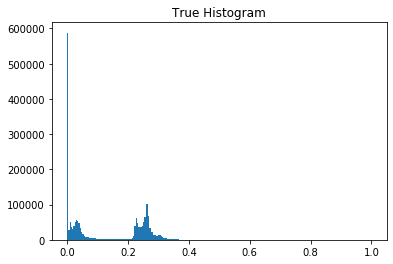

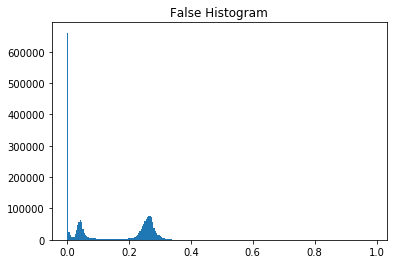

In [8]:
plt.hist(np.ravel(true_array), bins = 240)
plt.title('True Histogram')
plt.show()

plt.hist(np.ravel(output), bins = 240)
plt.title('False Histogram')
plt.show()

In [9]:
import cv2 as cv
import numpy.ma as ma

def extract_slice_mask(slice):

    ret, thresh = cv.threshold(slice, 0.05, 1, cv.THRESH_BINARY)
    num_labels, labels_im, stats, centroids = cv.connectedComponentsWithStats(thresh.astype('uint8'))

    max = stats[1, 4]
    largest_index = 1

    for k in np.delete(np.unique(labels_im), 0):

        size = stats[k, 4]
        if (size > max):

            max = size
            largest_index = k

    mask = ma.masked_not_equal(labels_im, largest_index)
    return mask

def extract_lung_mask(volume, size = 128):

    slices = []

    for i in range(0, size):

        masked_slice = extract_slice_mask(volume[i])
        slices.append(masked_slice)

    slices = np.array(slices)
    return slices


mask_false = ma.masked_not_equal(extract_lung_mask(output, size = 128), 1)
mask_true = ma.masked_not_equal(extract_lung_mask(true_array, size = 128), 1)

In [10]:


def extract_slice_mask(slice):

    ret, thresh = cv.threshold(slice, 0.1, 1, cv.THRESH_BINARY)
    num_labels, labels_im, stats, centroids = cv.connectedComponentsWithStats(thresh.astype('uint8'))

    max = stats[1, 4]
    largest_index = 1

    for k in np.delete(np.unique(labels_im), 0):

        size = stats[k, 4]
        if (size > max):

            max = size
            largest_index = k

    mask = ma.masked_not_equal(labels_im, largest_index)
    return mask

def extract_lung_mask(volume, size = 128):

    slices = []

    for i in range(0, size):

        masked_slice = extract_slice_mask(volume[i])
        slices.append(masked_slice)

    slices = np.array(slices)
    return slices

def tpfp(truth, prediction):

    h, w, l = truth.shape[0], truth.shape[1], truth.shape[2]

    tp = np.zeros(truth.shape)
    fp = np.zeros(truth.shape)
    fn = np.zeros(truth.shape)
    tn = np.zeros(truth.shape)

    truth_mask = extract_lung_mask(truth)
    pred_mask = extract_lung_mask(prediction)

    for i in range(0, h):

        for j in range(0, w):

            for k in range(0, l):

                if (truth_mask[i, j, k] == 1 and pred_mask[i, j, k] == 1):

                    tp[i, j, k] = 1

                elif (truth_mask[i, j, k] == 1 and pred_mask[i, j, k] == 0):

                    fn[i, j, k] = 1

                elif (truth_mask[i, j, k] == 0 and pred_mask[i, j, k] == 1):

                    fp[i, j, k] = 1

                else:

                    tn[i, j, k] = 1

    tp = ma.masked_values(tp * 100, 0)
    fp = ma.masked_values(fp * 50, 0)
    fn = ma.masked_values(fn, 0)
    
    prdd = pred_mask[64]
    trdd = truth_mask[64]

    return tp, fp, fn

In [22]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

import numpy as np
from skimage import measure

def plot_tpfp(tp, fp, fn):
    fig = plt.figure(figsize = (10, 10))
    ax = fig.add_subplot(111, projection = '3d')
    face_color_tp = [0.5, 1, 0.5]
    face_color_fp = [0.5, 0.5, 1]
    face_color_fn = [1, 0.5, 0.5]
    
    lis = [tp, fp, fn]
    face_color_lis = [face_color_tp, face_color_fp, face_color_fn]
    alphas = [0.2, 0.5, 0.5]
    
    for i in range(len(lis)):
        
        image = lis[i]
        p = image.transpose(2, 1, 0)
        verts, faces, normals, values = measure.marching_cubes_lewiner(p)
        mesh = Poly3DCollection(verts[faces], alpha = alphas[i])
        mesh.set_facecolor(face_color_lis[i])
        ax.add_collection3d(mesh)
        ax.set_xlim(0, p.shape[0])
        ax.set_ylim(0, p.shape[1])
        ax.set_zlim(0, p.shape[2])
    
    plt.show()
    
tp, fp, fn = tpfp(true_array, output)
#plot_tpfp(tp, fp, fn)

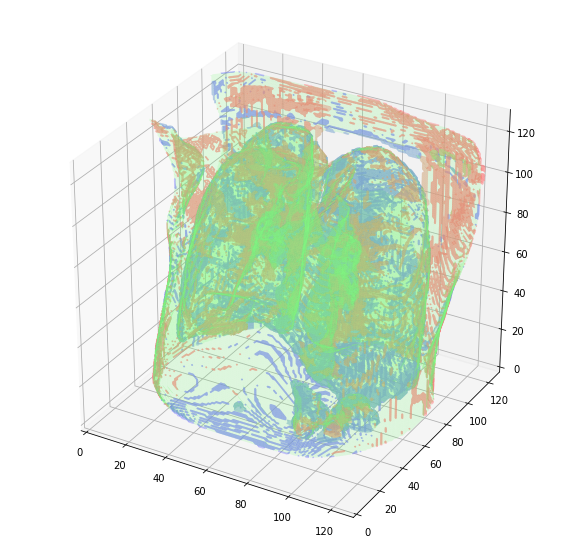

In [23]:
plot_tpfp(tp, fp, fn)

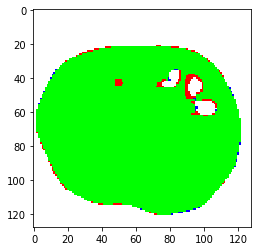

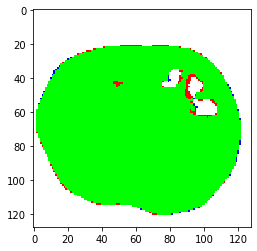

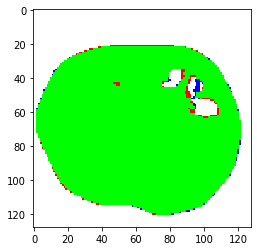

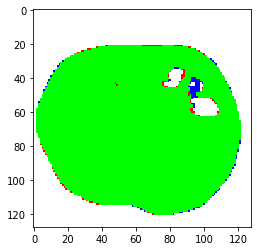

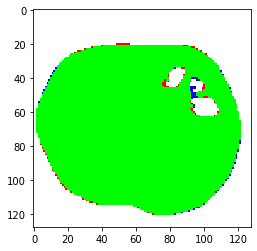

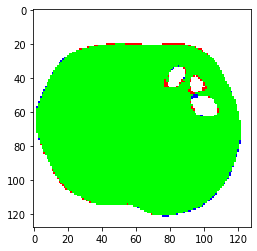

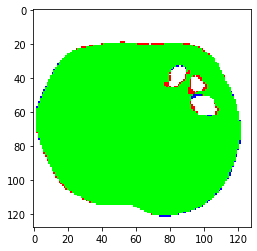

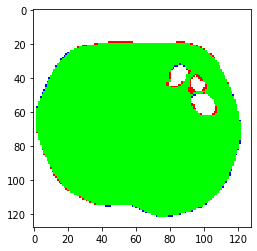

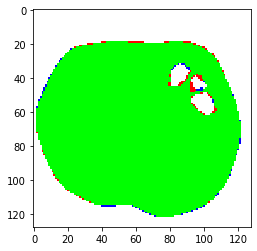

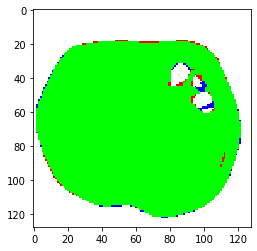

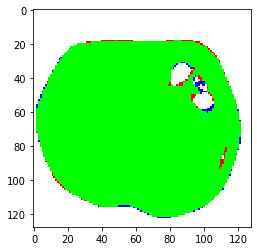

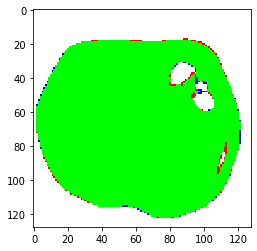

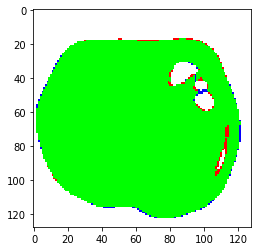

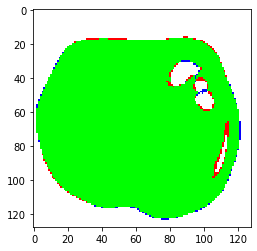

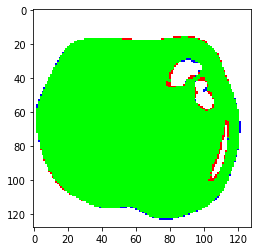

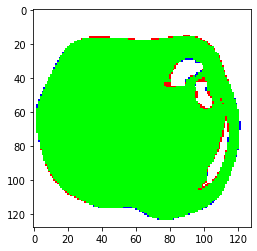

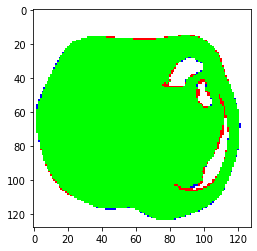

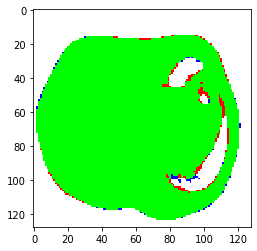

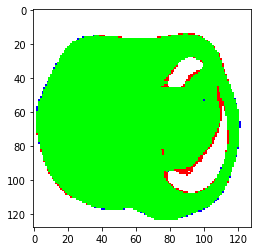

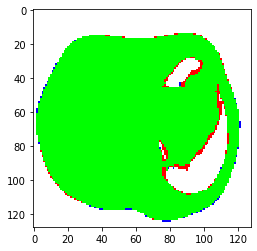

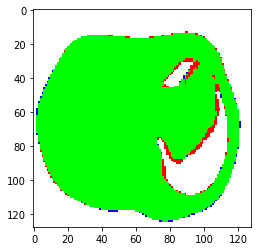

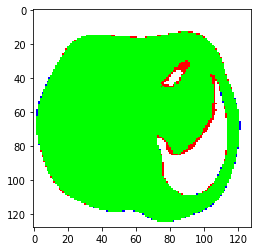

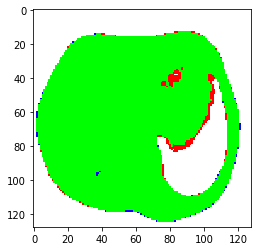

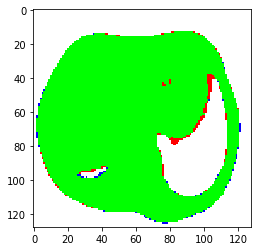

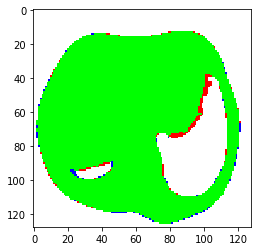

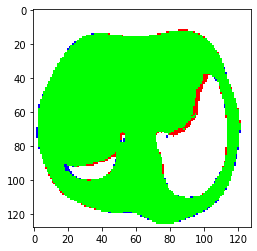

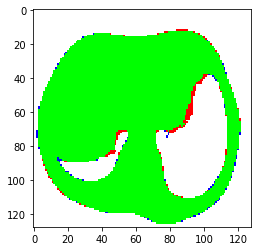

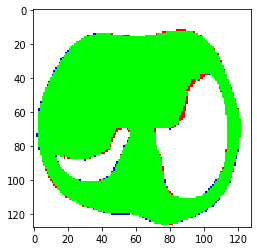

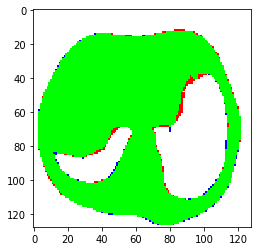

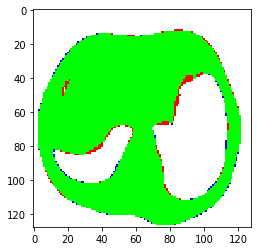

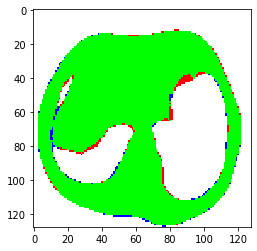

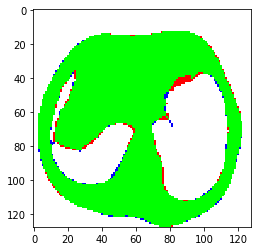

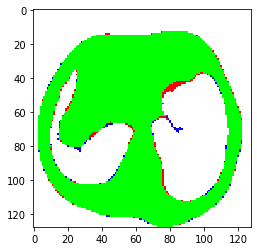

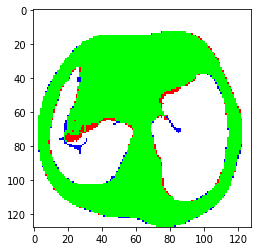

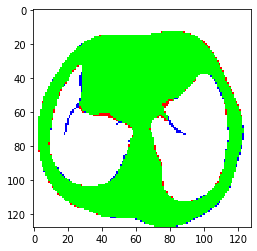

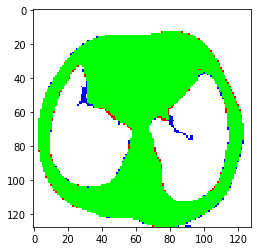

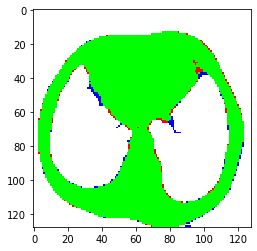

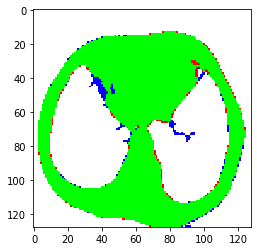

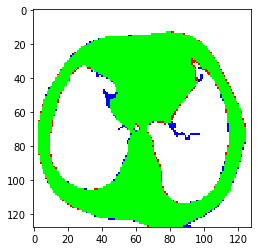

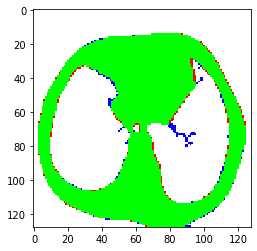

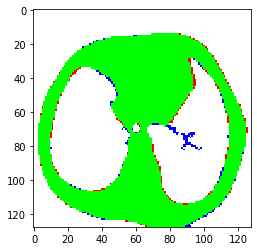

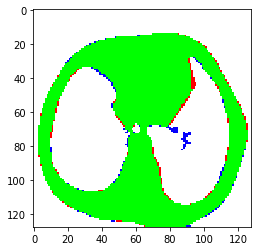

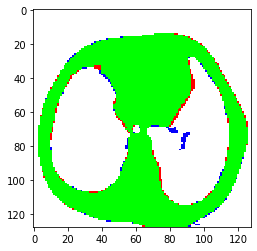

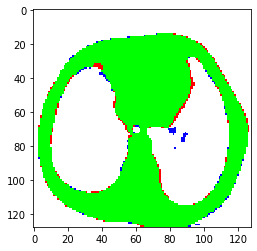

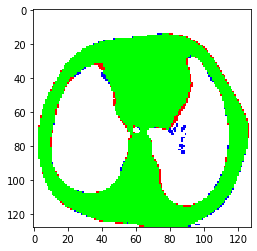

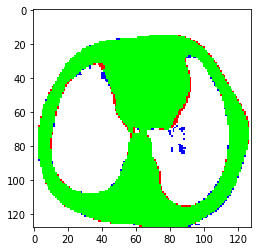

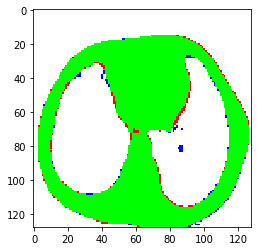

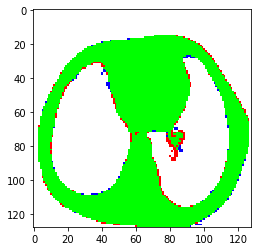

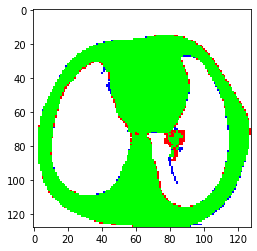

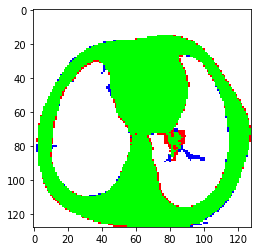

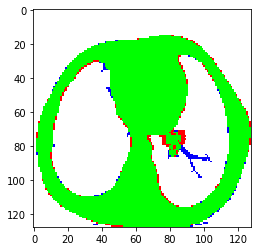

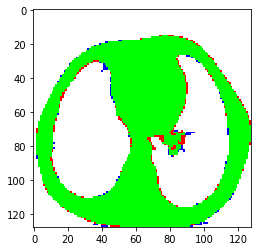

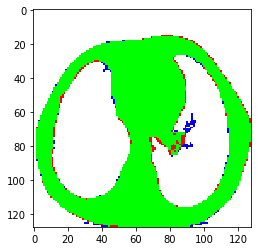

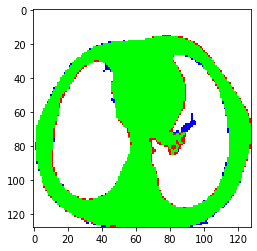

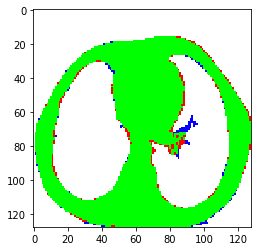

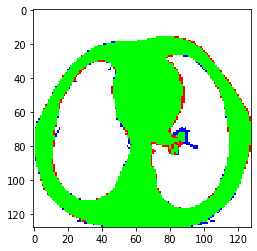

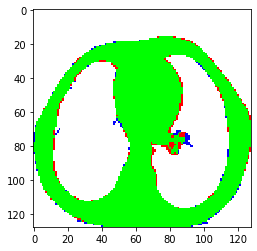

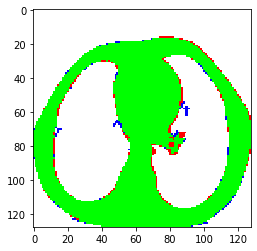

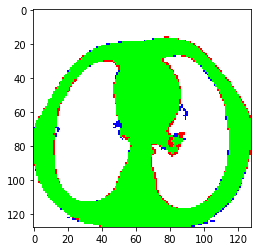

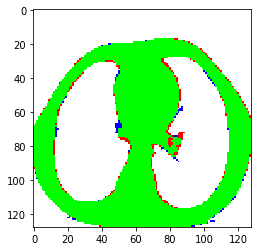

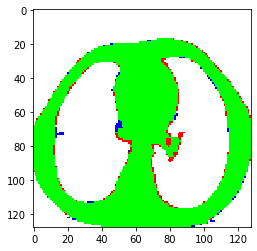

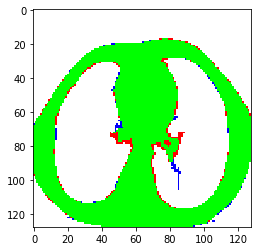

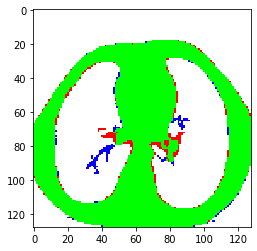

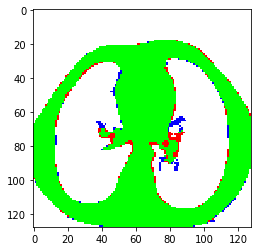

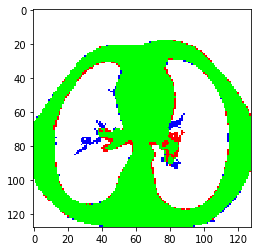

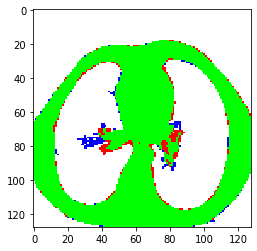

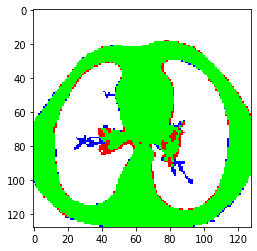

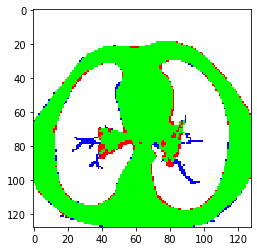

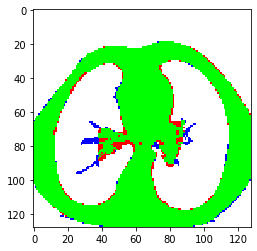

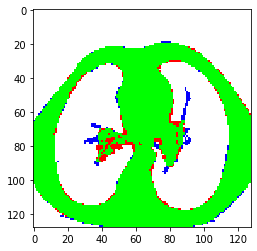

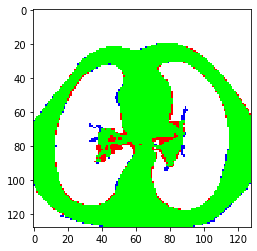

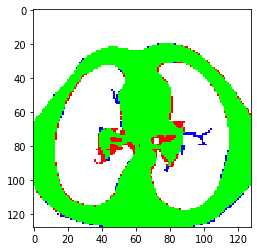

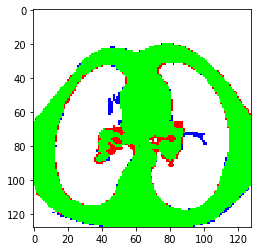

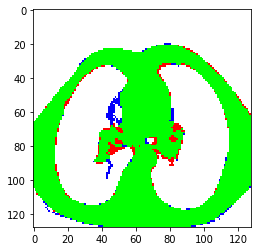

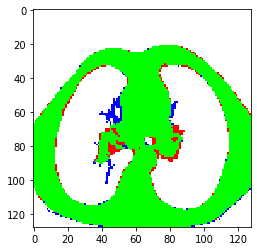

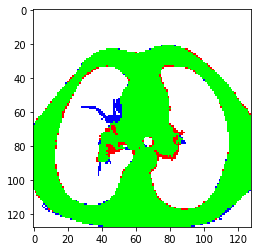

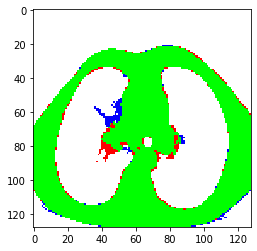

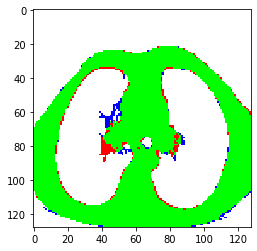

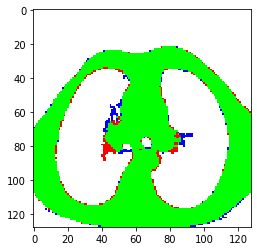

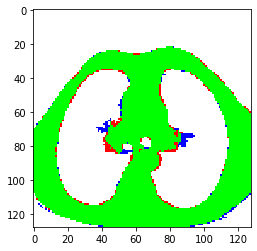

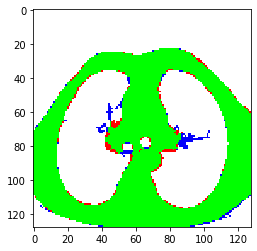

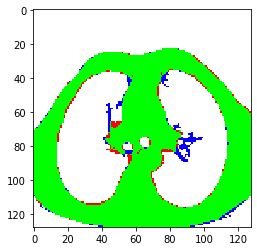

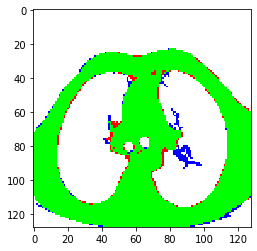

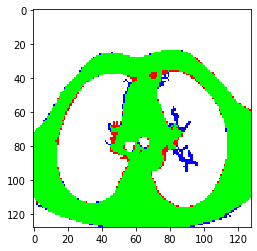

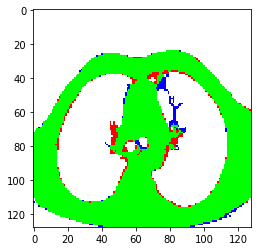

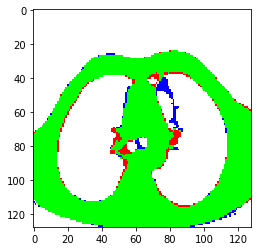

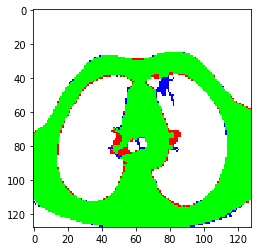

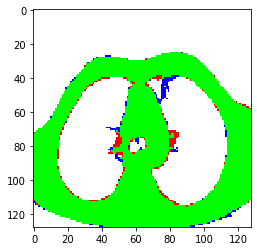

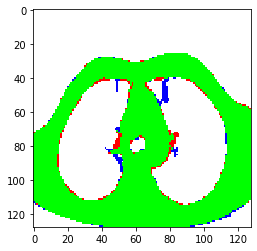

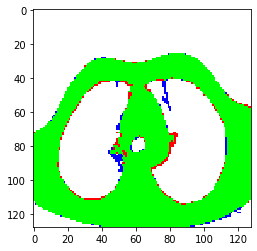

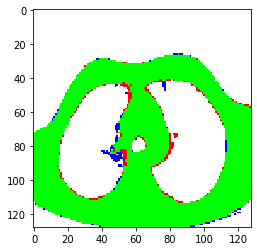

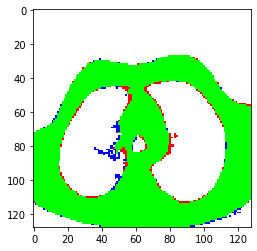

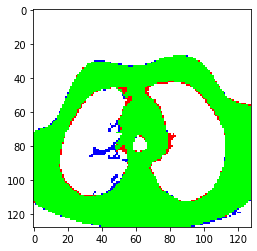

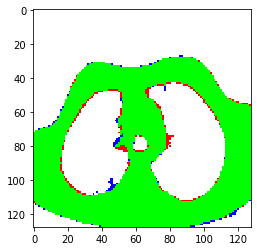

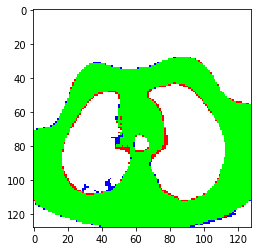

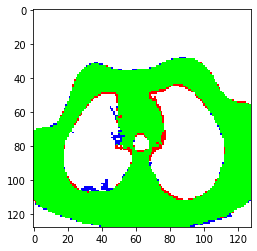

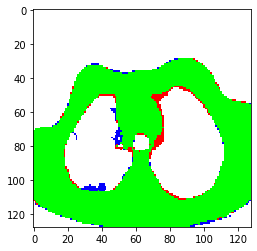

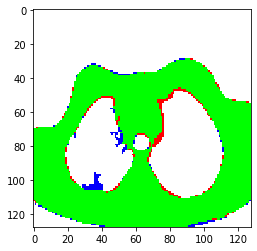

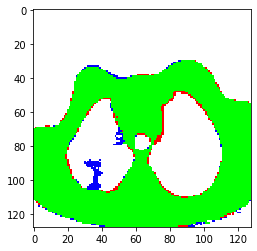

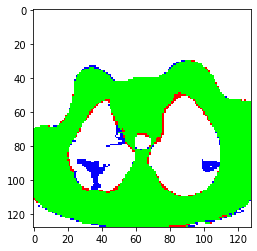

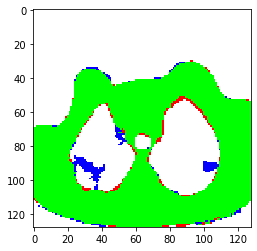

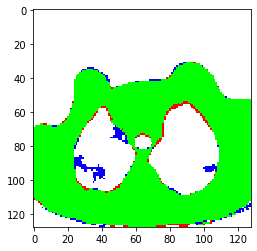

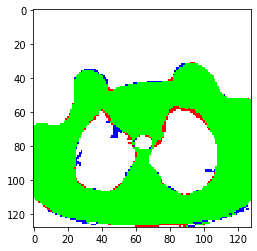

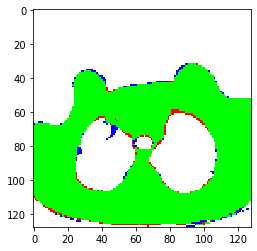

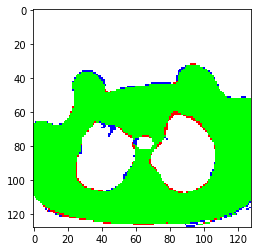

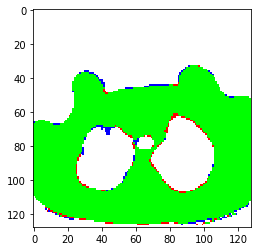

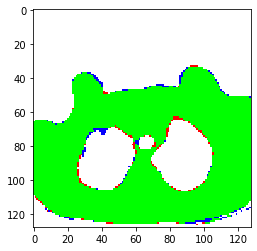

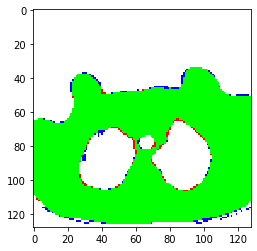

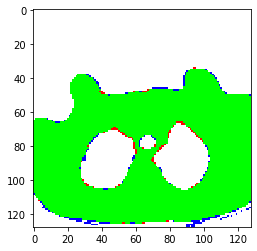

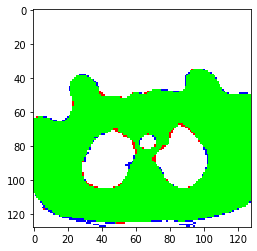

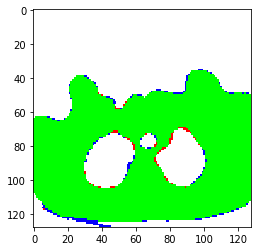

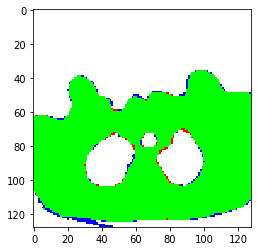

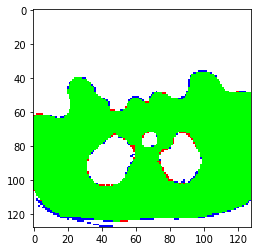

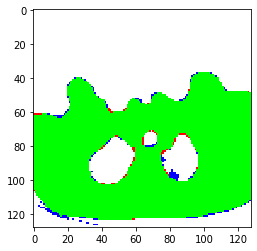

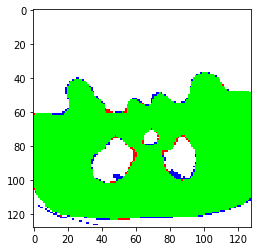

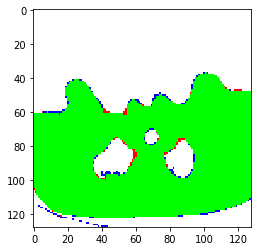

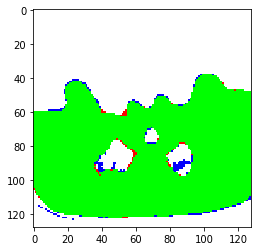

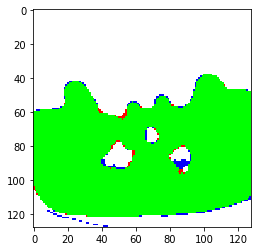

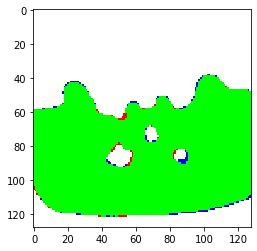

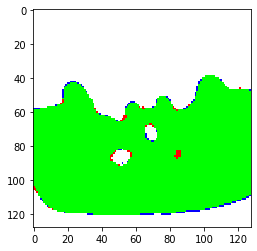

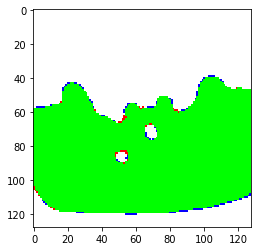

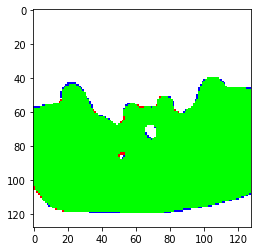

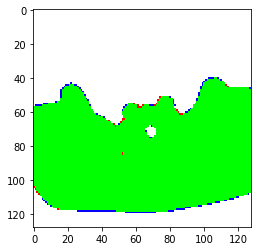

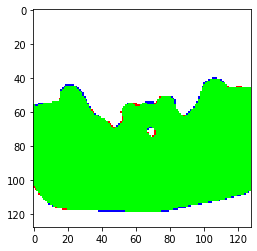

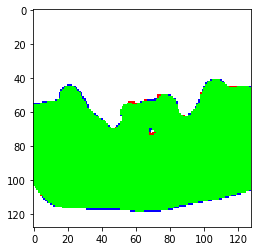

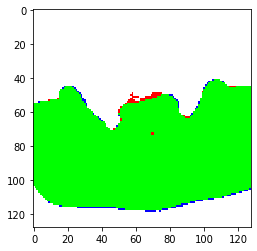

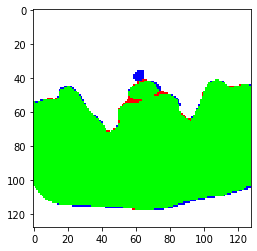

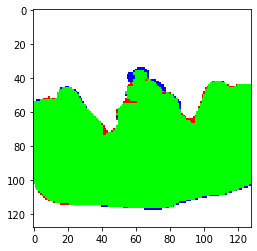

In [19]:
for i in range(0, 128):
    
    plt.imshow(tp[i], cmap = 'brg', vmin = 0.1)
    plt.imshow(fp[i], cmap = 'brg', vmin = 0.1, vmax = 100)
    plt.imshow(fn[i], cmap = 'brg', vmin = 0.1, vmax = 90)
    plt.show(block = True)

In [24]:
def dice_score(im1, im2, empty_score=1.0):
    """
    Computes the Dice coefficient, a measure of set similarity.
    Parameters
    ----------
    im1 : array-like, bool
        Any array of arbitrary size. If not boolean, will be converted.
    im2 : array-like, bool
        Any other array of identical size. If not boolean, will be converted.
    Returns
    -------
    dice : float
        Dice coefficient as a float on range [0,1].
        Maximum similarity = 1
        No similarity = 0
        Both are empty (sum eq to zero) = empty_score
        
    Notes
    -----
    The order of inputs for `dice` is irrelevant. The result will be
    identical if `im1` and `im2` are switched.
    """
    im1 = np.asarray(im1).astype(np.bool)
    im2 = np.asarray(im2).astype(np.bool)

    if im1.shape != im2.shape:
        raise ValueError("Shape mismatch: im1 and im2 must have the same shape.")

    im_sum = im1.sum() + im2.sum()
    if im_sum == 0:
        return empty_score

    # Compute Dice coefficient
    intersection = np.logical_and(im1, im2)

    return 2. * intersection.sum() / im_sum

print(dice_score(extract_lung_mask(true_array), extract_lung_mask(output)))

0.9704420622850758


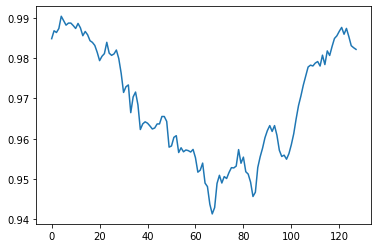

In [25]:
true_lung_mask = extract_lung_mask(true_array)
false_lung_mask = extract_lung_mask(output)

dices = []

for i in range(0, 128):
    
    true_mask_slice = true_lung_mask[i]
    false_mask_slice = false_lung_mask[i]
    
    dices.append(dice_score(true_mask_slice, false_mask_slice))

plt.plot(dices)
plt.show()

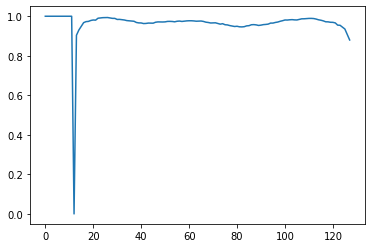

In [29]:
forwards_dices = []

for i in range(0, 128):
    
    true_mask_slice = true_lung_mask[:, i]
    false_mask_slice = false_lung_mask[:, i]
    
    forwards_dices.append(dice_score(true_mask_slice, false_mask_slice))

plt.plot(forwards_dices)
plt.show()

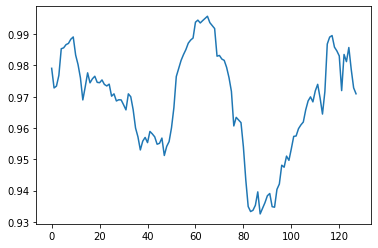

In [31]:
sideways_dices = []

for i in range(0, 128):
    
    true_mask_slice = true_lung_mask[:, :, i]
    false_mask_slice = false_lung_mask[:, :, i]
    
    sideways_dices.append(dice_score(true_mask_slice, false_mask_slice))

plt.plot(sideways_dices)
plt.show()

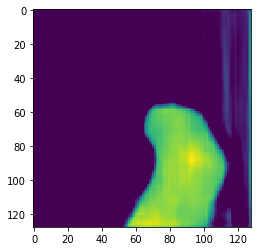

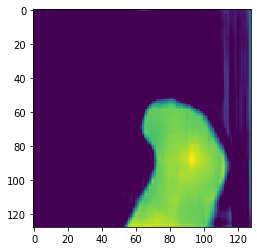

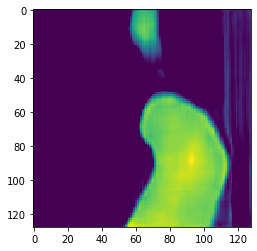

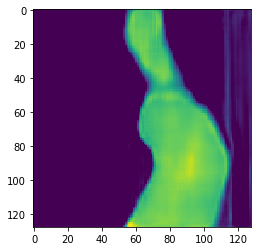

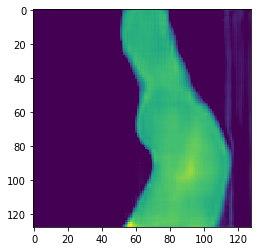

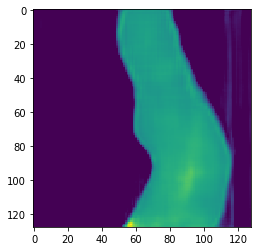

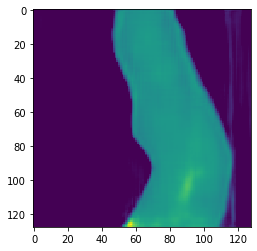

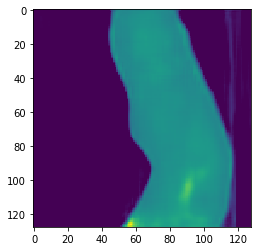

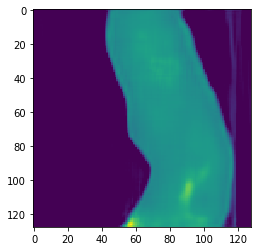

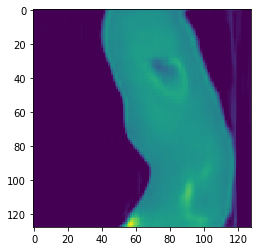

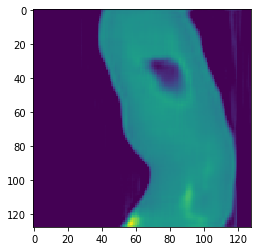

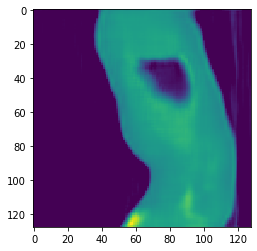

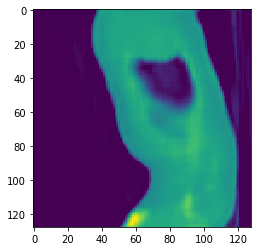

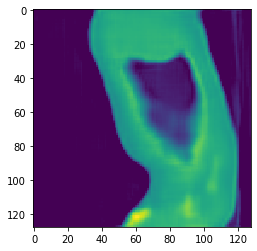

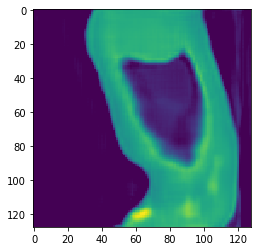

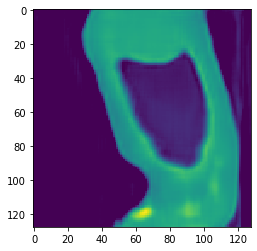

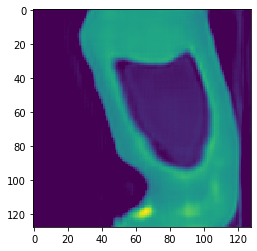

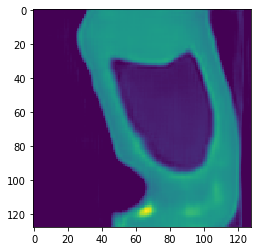

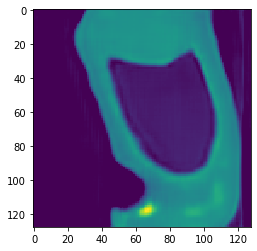

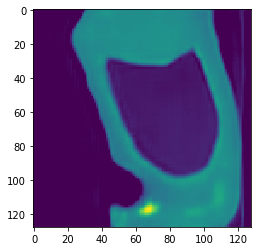

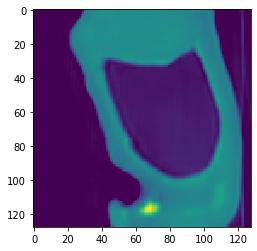

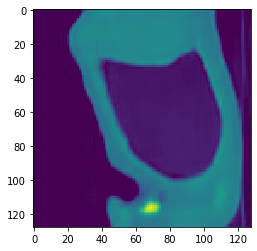

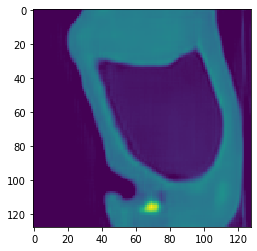

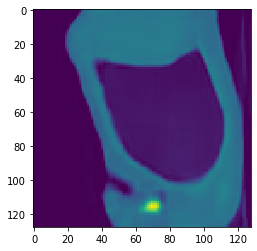

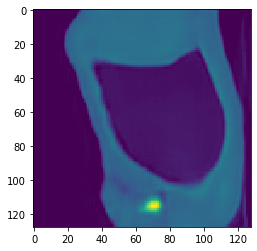

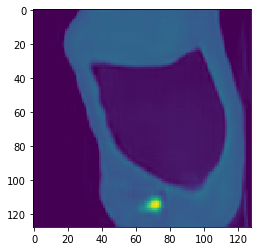

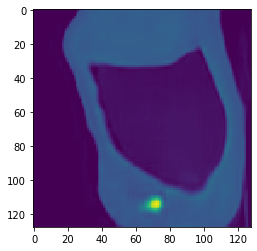

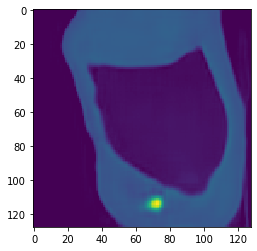

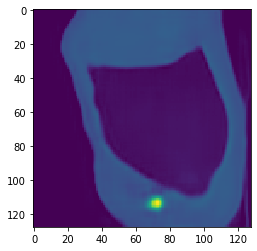

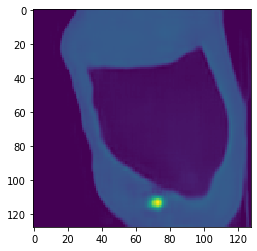

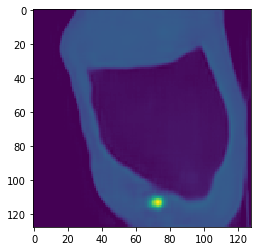

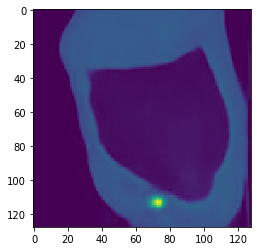

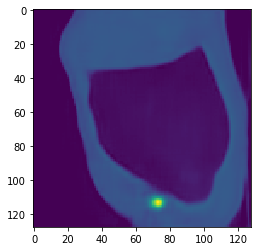

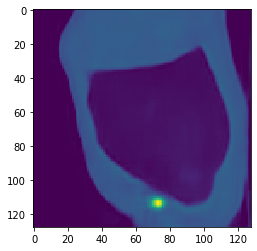

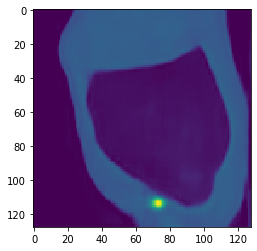

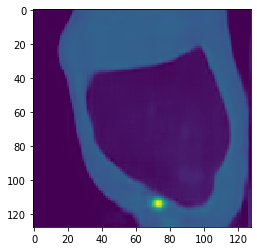

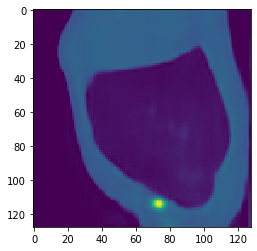

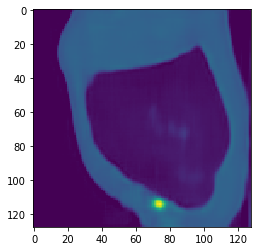

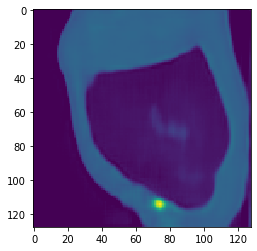

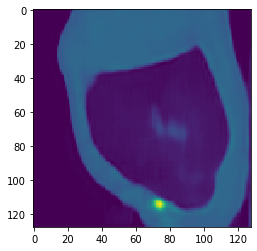

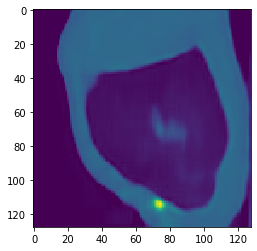

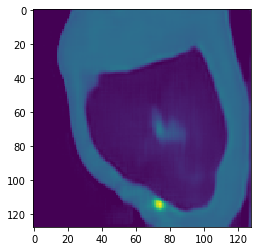

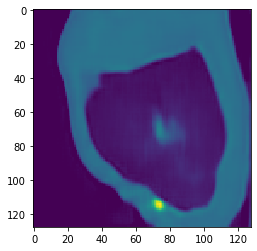

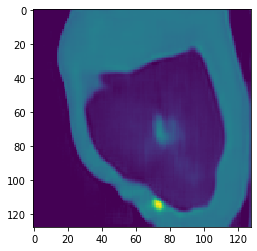

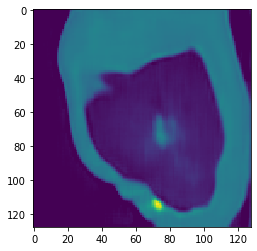

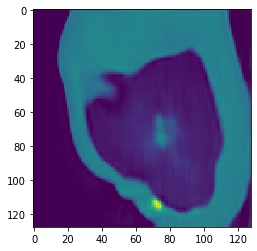

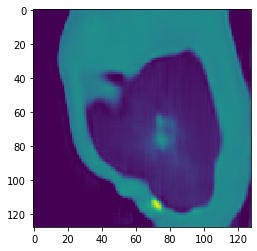

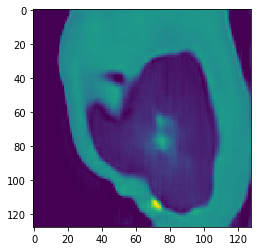

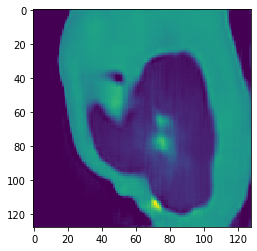

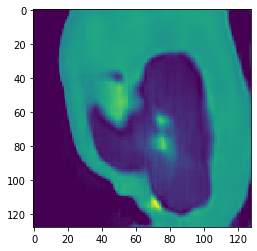

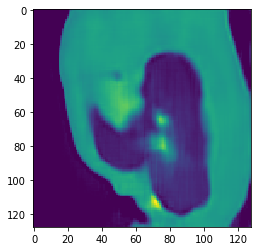

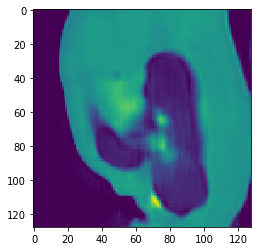

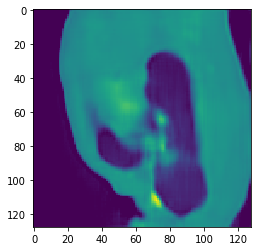

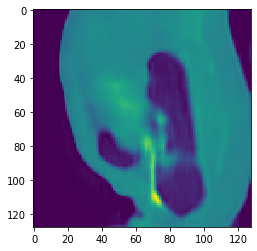

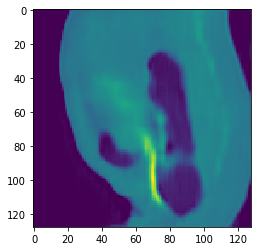

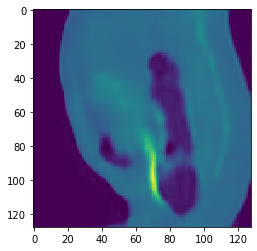

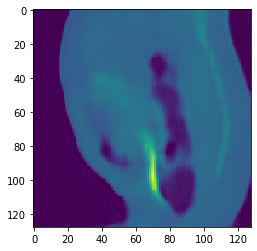

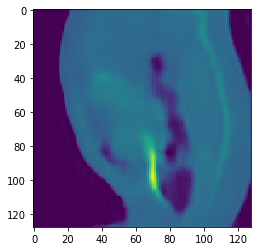

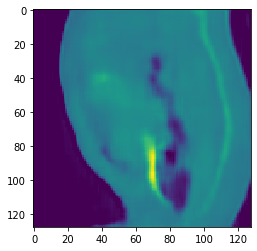

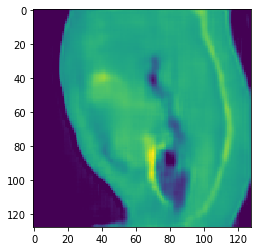

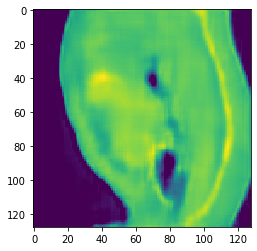

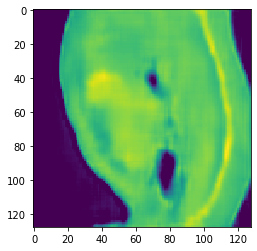

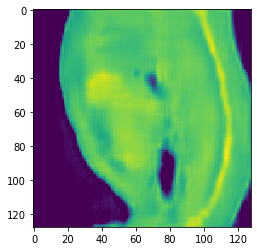

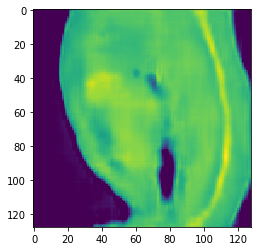

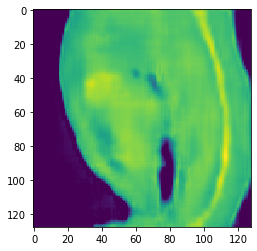

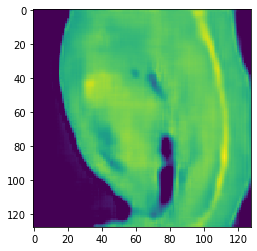

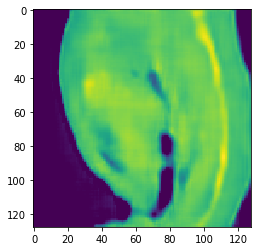

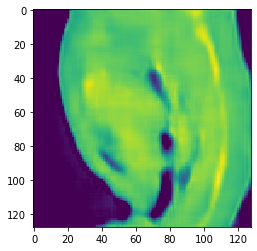

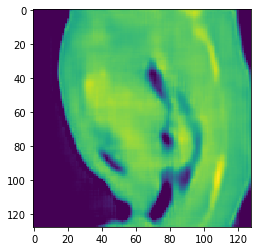

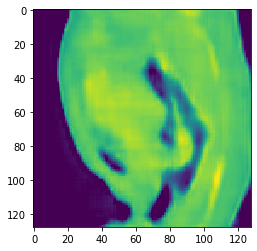

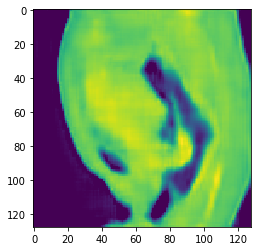

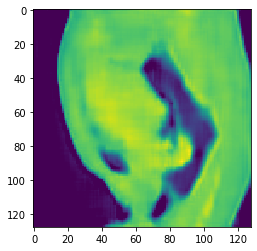

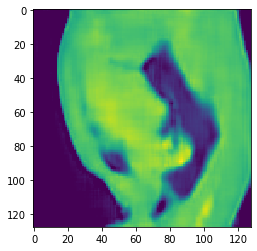

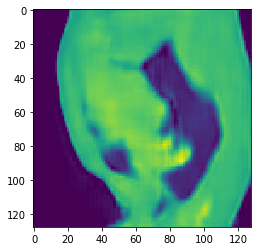

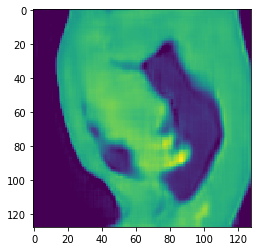

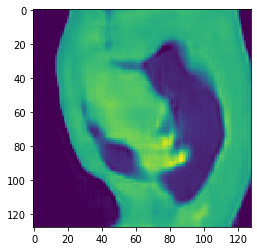

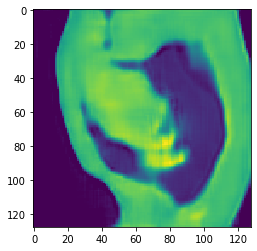

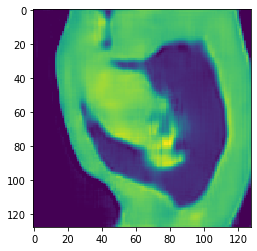

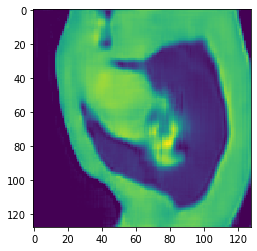

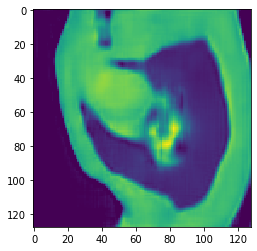

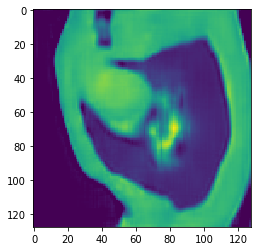

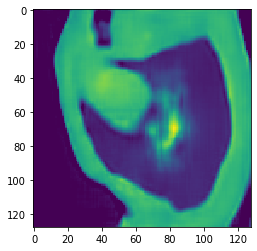

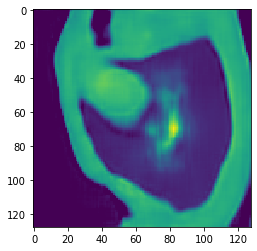

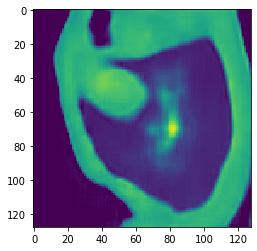

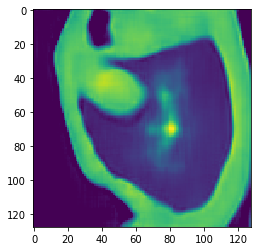

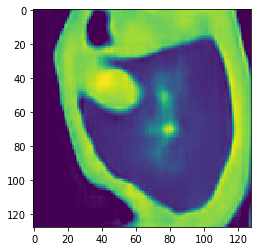

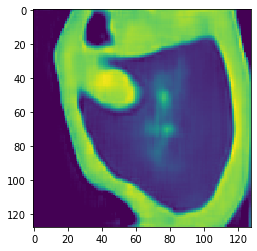

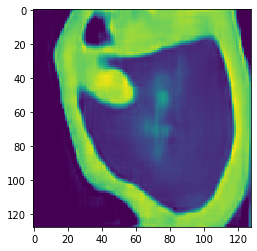

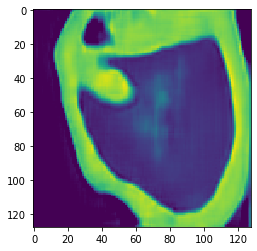

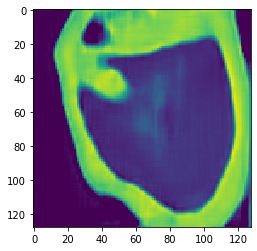

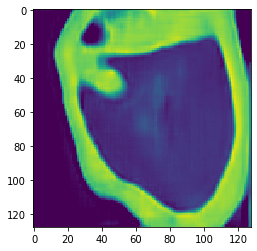

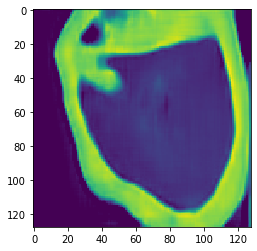

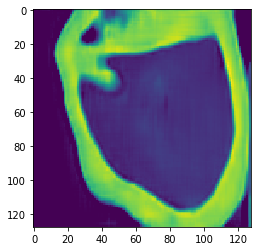

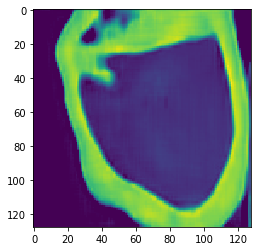

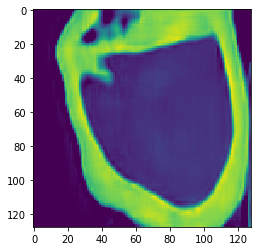

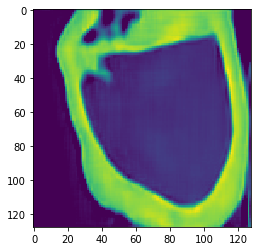

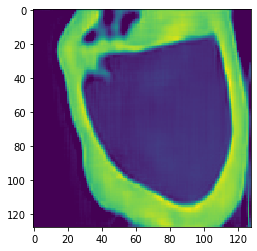

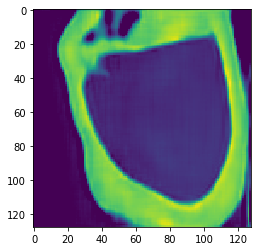

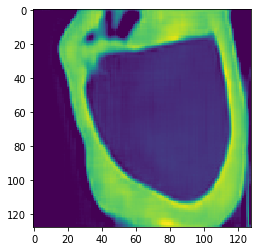

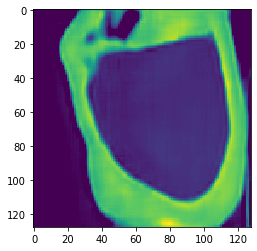

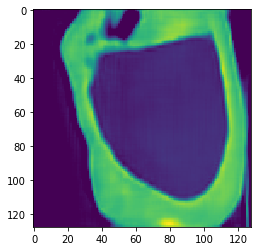

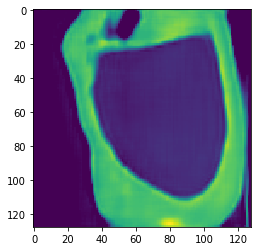

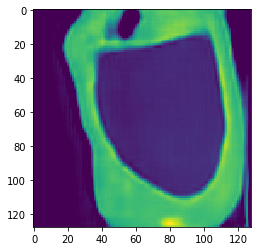

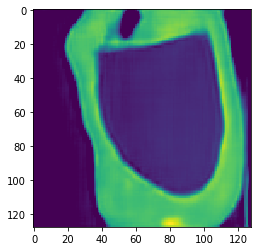

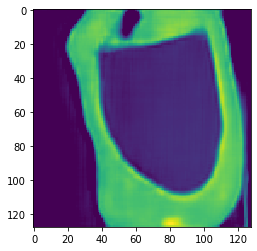

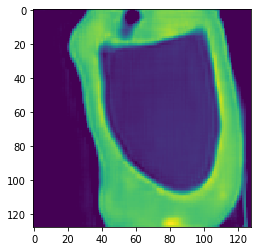

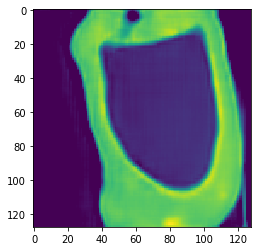

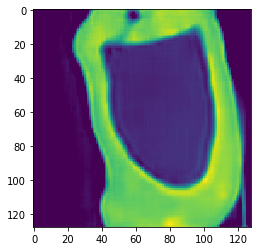

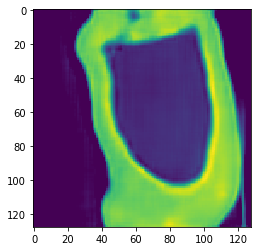

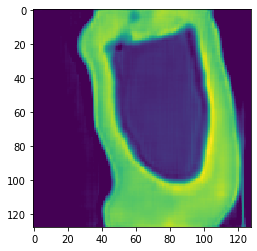

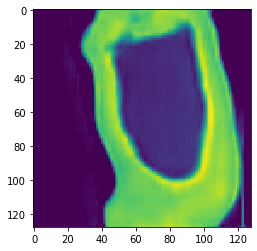

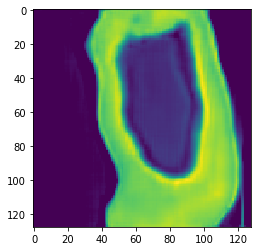

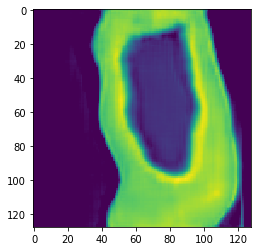

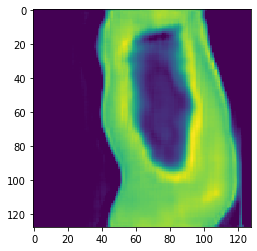

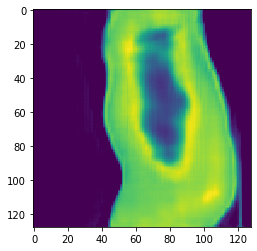

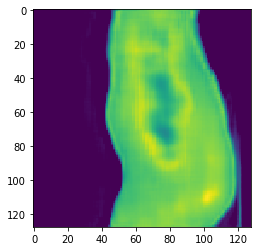

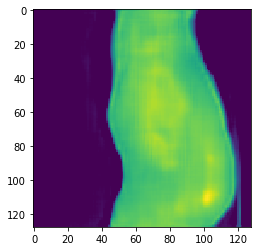

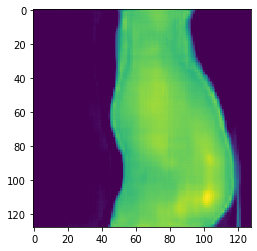

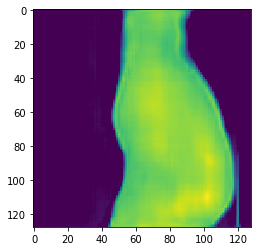

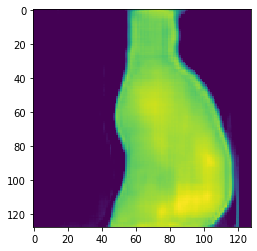

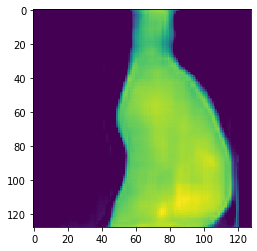

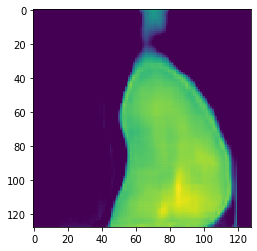

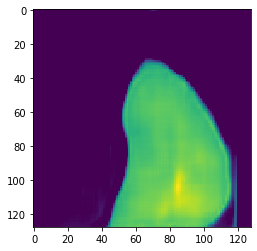

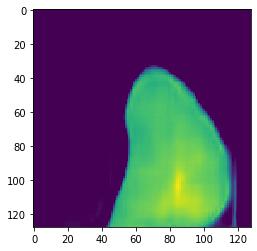

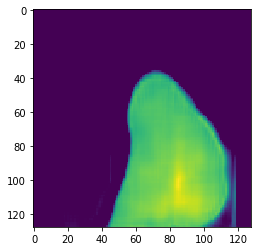

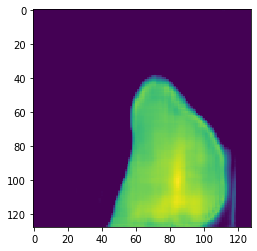

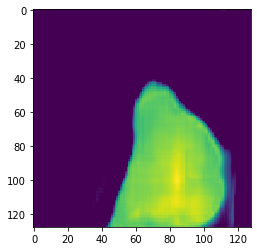

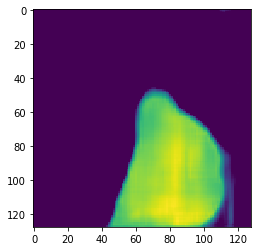

In [32]:
for i in range(0, 128):
    
    plt.imshow(output[:, :, i])
    plt.show()
    


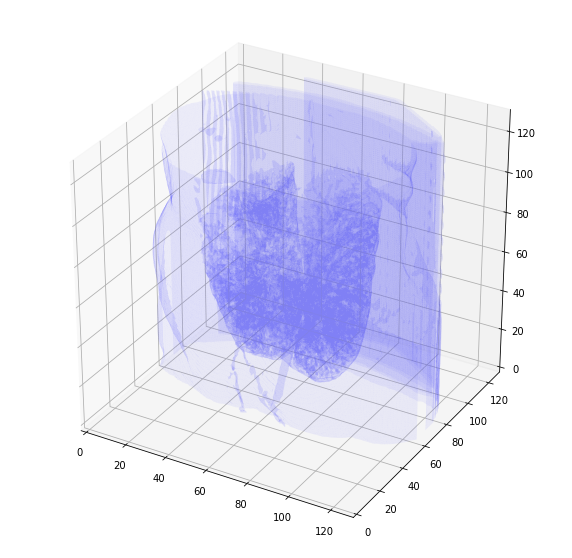

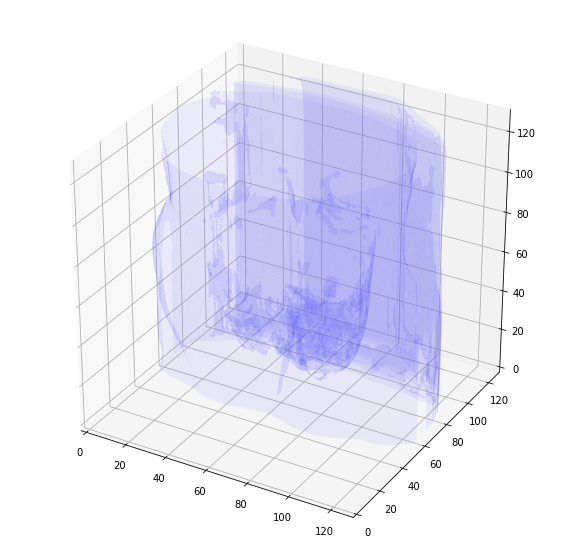

In [13]:


def plot_3d(image, threshold=-300): 
    p = image.transpose(2,1,0)
    verts, faces, normals, values = measure.marching_cubes_lewiner(p, threshold)
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    mesh = Poly3DCollection(verts[faces], alpha=0.1)
    face_color = [0.5, 0.5, 1]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)
    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()
    
plot_3d(true_array, 0.1)
plot_3d(false_array, 0.1)